# Data description and plots for figure 1

In this file we gather all the three component of our analyses : the POC mean sequestration time, krill density and krill catch density.

We first make sure that the cooridnates systems and the resolution of all file are harmonised and plot them.
We also print in this file the stat description of the data (some numbers are re-used in the manuscript).

In [4]:
# import libraries (ok sous base anaconda)
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import math
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [5]:
# To be change with local directory of the data (file too heavy to be on git)
#os.chdir('./Key_Areas_krill_carbon_sequestration/outputs_formated_data/')
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/')

# Load data

- Krill population
- Mean sequestration time
- Krill catch

Rename the variable when needed and transform into dataset

Create a joined dataframe

In [5]:
krill_pop = xr.open_dataset('./outputs_formated_data/Krill_biomass_final.nc')['krill_adult_log']
krill_pop_krillbase = xr.open_dataset('./outputs_formated_data/Krill_density_krillbase_final.nc')["STANDARDISED_KRILL_UNDER_1M2_log"]
mean_time_seq = xr.open_dataset('./outputs_formated_data/xr_mean_time_seq_final.nc')
krill_pop_krillbase

<xarray.DataArray 'STANDARDISED_KRILL_UNDER_1M2_log' (LATITUDE_largegrid: 16,
                                                      LONGITUDE_largegrid: 180)>
[2880 values with dtype=float64]
Coordinates:
  * LATITUDE_largegrid   (LATITUDE_largegrid) int32 -77 -75 -73 ... -51 -49 -47
  * LONGITUDE_largegrid  (LONGITUDE_largegrid) int32 -179 -177 -175 ... 177 179

In [6]:
mean_time_seq = mean_time_seq.rename_vars({'__xarray_dataarray_variable__' : 'mean_seq_time' })

In [7]:
# transform into dataframe
krill_pop = krill_pop.to_dataframe().reset_index().drop(['time'], axis =1) # 3600 rows × 3 columns
krill_pop_krillbase = krill_pop_krillbase.to_dataframe().reset_index()
mean_time_seq = mean_time_seq.to_dataframe().reset_index().drop(['variable'], axis =1) # 3240 rows × 3 columns
catch = catch.to_dataframe().reset_index().drop(['variable'], axis =1) # 1800 rows × 3 columns

In [8]:
# checks for krill pop
krill_pop = krill_pop.dropna()[krill_pop['krill_adult_log'] != 0]
krill_pop.set_index(['latitude', 'longitude'], inplace = True) #1815  rows × 3 columns
krill_pop

C:\Users\anael\AppData\Local\Temp\ipykernel_50100\1392448703.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  krill_pop = krill_pop.dropna()[krill_pop['krill_adult_log'] != 0]


krill_adult_log
latitude longitude                 
-77      -179               0.57452
         -177               0.81818
         -175               1.00264
         -173               0.99747
         -171               1.14972
...                             ...
-45       63                0.00001
          65                0.00762
          67                0.10288
          69                0.05762
          71                0.00012

[1890 rows x 1 columns]

In [9]:
krill_pop.describe()

,krill_adult_log
count,1890.000000
mean,1.295430
std,0.676096
min,0.000010
25%,0.912840
50%,1.334205
75%,1.753180
max,4.010510


In [10]:
krill_pop.quantile(q=[0.3333, 0.6666])

,krill_adult_log
0.3333,1.09418
0.6666,1.59819


In [11]:
# checks for krill pop
krill_pop_krillbase = krill_pop_krillbase.dropna()
krill_pop_krillbase.set_index(['LATITUDE_largegrid', 'LONGITUDE_largegrid'], inplace = True) #1815  rows × 3 columns

krill_pop_krillbase.describe()

,STANDARDISED_KRILL_UNDER_1M2_log
count,1063.000000
mean,0.563900
std,0.692304
min,0.000000
25%,0.000000
50%,0.184786
75%,0.995160
max,2.744040


In [12]:
krill_pop_krillbase

STANDARDISED_KRILL_UNDER_1M2_log
LATITUDE_largegrid LONGITUDE_largegrid                                  
-77                -49                                          0.000000
                   -47                                          0.000000
                   -45                                          0.000000
                   -43                                          0.154302
                   -41                                          0.154302
...                                                                  ...
-47                 67                                          0.000000
                    69                                          0.000000
                    71                                          0.000000
                    73                                          0.000000
                    75                                          0.000000

[1063 rows x 1 columns]

In [13]:
krill_array = xr.Dataset.from_dataframe(krill_pop) # convert into xarrayDataset
krill_array = xr.Dataset.to_array(krill_array)

krill_pop_krillbase_array = xr.Dataset.from_dataframe(krill_pop_krillbase) # convert into xarrayDataset
krill_pop_krillbase_array = xr.Dataset.to_array(krill_pop_krillbase_array)

### Sequestration time

In [14]:
# checks for mean time seq : 513 NaN rows 
mean_time_seq = mean_time_seq.dropna() #2727 
mean_time_seq = mean_time_seq.set_index(['latitude', 'longitude'])
mean_time_seq

mean_seq_time
latitude longitude               
-75      -179          646.910548
         -177          601.882341
         -175          655.238074
         -173          641.075711
         -171          620.753036
...                           ...
-45       167           -0.000000
          173          162.285177
          175          131.782475
          177          207.926560
          179          117.346934

[2384 rows x 1 columns]

In [15]:
mean_time_seq.describe()

,mean_seq_time
count,2384.000000
mean,399.260564
std,166.306270
min,-0.000000
25%,290.831076
50%,361.746806
75%,507.394900
max,1064.161761


#### Merge sequestration time data on krill distribution area

In [34]:
mean_time_seq_studyarea = mean_time_seq.merge(krill_pop, left_index=True, right_index=True, how='inner').drop(['krill_adult_log'], axis=1)
mean_time_seq_studyarea # 1773 

mean_seq_time
latitude longitude               
-75      -179          646.910548
         -177          601.882341
         -175          655.238074
         -173          641.075711
         -171          620.753036
...                           ...
-45       63           320.323902
          65           257.610200
          67           238.034583
          69           314.399618
          71           306.357993

[1773 rows x 1 columns]

In [30]:
mean_time_seq_studyarea.describe()

,mean_seq_time,krill_adult_log
count,1773.000000,1773.000000
mean,445.129102,1.248879
std,163.763630,0.647892
min,-0.000000,0.000010
25%,343.808867,0.874380
50%,411.508309,1.301940
75%,563.785216,1.706170
max,1064.161761,3.547060


In [17]:
mean_time_seq_array = xr.Dataset.from_dataframe(mean_time_seq) # convert into xarrayDataset
mean_time_seq_array = xr.Dataset.to_array(mean_time_seq_array)

In [35]:
mean_time_seq_array_studyarea = xr.Dataset.from_dataframe(mean_time_seq_studyarea) # convert into xarrayDataset
mean_time_seq_array_studyarea = xr.Dataset.to_array(mean_time_seq_array_studyarea)

In [18]:
# checks for krill catch 940 to 227 without nan
catch = catch.dropna()
catch.set_index(['latitude', 'longitude'], inplace = True)
catch

krill_greenweight_kg_log
latitude longitude                          
-69       5                         1.420883
          7                         0.001813
          9                         0.001086
          13                        2.759430
          29                        3.221415
...                                      ...
-53      -35                        6.628269
         -7                         1.298297
          35                        0.678965
          37                        4.051270
-51      -37                        2.817927

[227 rows x 1 columns]

In [19]:
catch.describe()

,krill_greenweight_kg_log
count,227.000000
mean,2.527983
std,1.893472
min,0.000000
25%,0.951791
50%,2.390590
75%,3.820170
max,7.384449


In [20]:
catch.quantile(q=[0.3333, 0.6666])

,krill_greenweight_kg_log
0.3333,1.701544
0.6666,3.085543


In [21]:
catch.sum() # 573.852191

krill_greenweight_kg_log    573.852191
dtype: float64

In [22]:
catch_array = xr.Dataset.from_dataframe(catch) # convert into xarrayDataset
catch_array = xr.Dataset.to_array(catch_array)

# Panels for Figure 1

In [23]:
os.getcwd()

'C:\\Users\\anael\\Documents\\PhD\\4_krill_fisheries_Carbon_seq_time\\Git_repo\\Key_Areas_krill_carbon_sequestration'

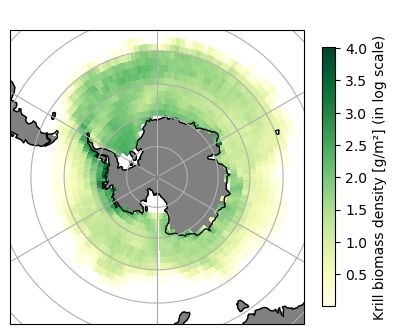

In [24]:
### KRILL POPULATION - KRILLPODYM
#os.chdir('./Key_Areas_krill_carbon_sequestration/figures/')
fig = plt.figure(figsize=(4, 4)) 
map_proj = ccrs.SouthPolarStereo()

p = krill_array.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap= "YlGn"
) 


p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'Krill biomass density [g/m²] (in log scale)', shrink = 0.7) 
plt.title(' ')
plt.tight_layout()

# plt.savefig('./figures/p_krill_krillpodym.png', bbox_inches = 'tight', dpi=300)
plt.show(p)

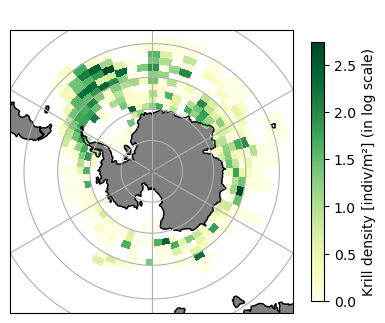

In [81]:
### KRILL POPULATION - KRILLBASE
#os.chdir('./Key_Areas_krill_carbon_sequestration/figures/')
#os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/figures')
fig = plt.figure(figsize=(4, 4)) 

map_proj = ccrs.SouthPolarStereo()

p = krill_pop_krillbase_array.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap= "YlGn"
) 


p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'Krill density [indiv/m²] (in log scale)', shrink = 0.7)

plt.title(' ')
plt.tight_layout()

# plt.savefig('./figures/p_krill_krillbase.png', bbox_inches = 'tight', dpi=300)
plt.show(p)

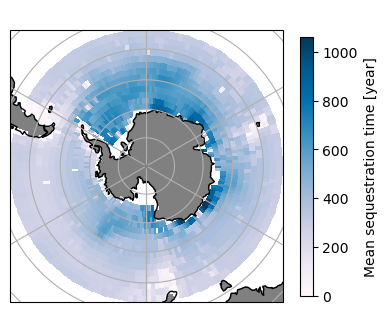

In [40]:
### MEAN TIME OF CARBON SEQUESTRATION
fig = plt.figure(figsize=(4, 4)) 

map_proj = ccrs.SouthPolarStereo()

p = mean_time_seq_array.plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap= "PuBu" #"Blues" #"YlGnBu"
)  # the plot's projection


p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'Mean sequestration time [year]', shrink = 0.7)#, boundaries = np.linspace(0,1100,100))
plt.title(' ')
plt.tight_layout()

plt.savefig('./figures/p_seq.png', bbox_inches = 'tight', dpi=300)


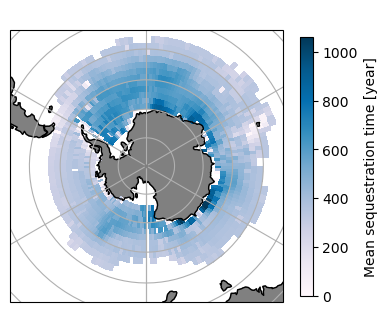

In [43]:
### MEAN TIME OF CARBON SEQUESTRATION
fig = plt.figure(figsize=(4, 4)) 

map_proj = ccrs.SouthPolarStereo()

p = mean_time_seq_array_studyarea.sortby(["latitude", "longitude"]).plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap= "PuBu" #"Blues" #"YlGnBu"
)  # the plot's projection


p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'Mean sequestration time [year]', shrink = 0.7)#, boundaries = np.linspace(0,1100,100))
plt.title(' ')
plt.tight_layout()

# plt.savefig('./figures/p_seq_study_area.png', bbox_inches = 'tight', dpi=300)


# Krill catch plots

Krill catch or density of catch

In [6]:
catch_all_years = xr.open_dataset('./outputs_formated_data/Krill_catch_array_final_all.nc')

catch_period1 = xr.open_dataset('./outputs_formated_data/Krill_catch_array_final_1.nc')
catch_period2 = xr.open_dataset('./outputs_formated_data/Krill_catch_array_final_2.nc')
catch_period3 = xr.open_dataset('./outputs_formated_data/Krill_catch_array_final_3.nc')

In [7]:
catch_period3

<xarray.Dataset>
Dimensions:                   (latitude: 10, longitude: 180)
Coordinates:
  * latitude                  (latitude) int32 -69 -67 -65 -63 ... -55 -53 -51
  * longitude                 (longitude) int32 -179 -177 -175 ... 175 177 179
Data variables:
    krill_greenweight_kg      (latitude, longitude) float64 ...
    krill_catch_density       (latitude, longitude) float64 ...
    krill_greenweight_kg_log  (latitude, longitude) float64 ...
    krill_catch_density_log   (latitude, longitude) float64 ...

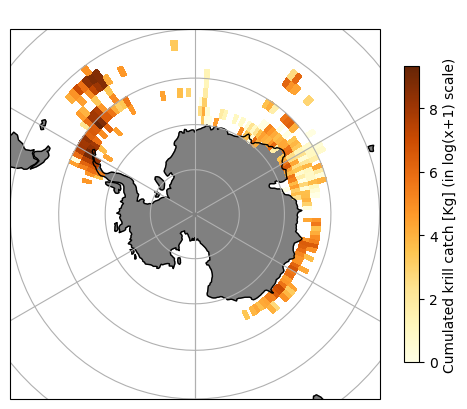

In [19]:
### KRILL CATCH
map_proj = ccrs.SouthPolarStereo()

p = catch_all_years['krill_greenweight_kg_log'].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap= "YlOrBr"
)


p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = 'Cumulated krill catch [Kg] (in log(x+1) scale)', shrink = 0.8) #, boundaries = np.linspace(0,8,100))
plt.title(' ') # Map of krill catch (average from 1988 to 2023)

# plt.savefig('./figures/p_catch.png')
plt.show()


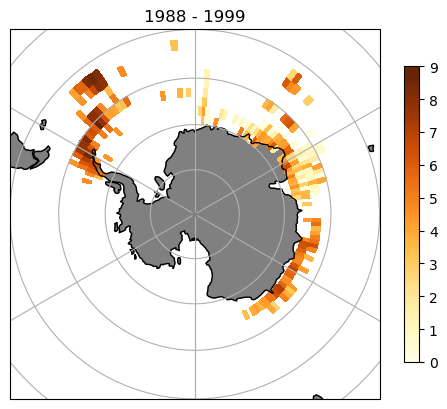

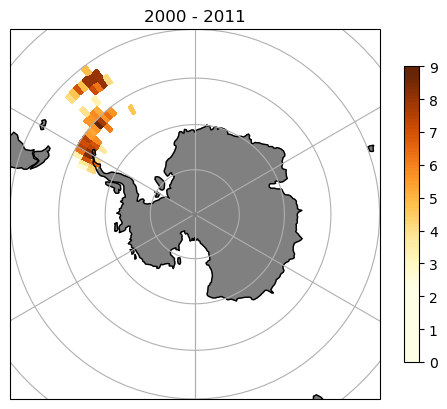

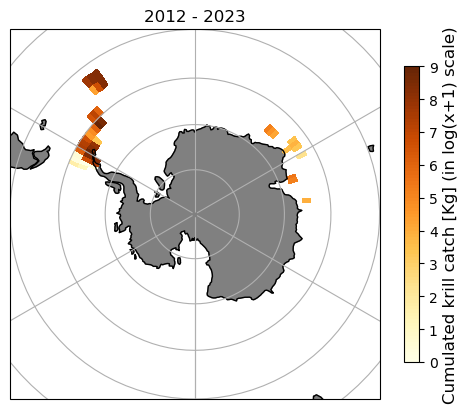

In [18]:
### Maps of krill catch per periods

# and save them as images
#os.chdir('./Key_Areas_krill_carbon_sequestration/figures/')


map_proj = ccrs.SouthPolarStereo()

# From 1988 to 2000 ###############
p1 = catch_period1['krill_greenweight_kg_log'].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap= "YlOrBr"
) 

p1.axes.gridlines()
p1.axes.add_feature(cfeature.LAND, color='grey')
p1.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p1, label = '', shrink = 0.8, boundaries = np.linspace(0,9,91))

# cb.set_label(label='Catch density [$Kg.(10^4 km²)^{-1}.year^{-1}$] (in log(x+1) scale)', size=13)
cax = cb.ax
# cax.axhline(2.085731, c='w', linewidth = 1)
# cax.axhline(3.506890, c='w')

plt.title('1988 - 1999')

# save
# plt.savefig('./figures/catch_period1.png', bbox_inches='tight', dpi=300)

plt.show()


# From 2000 to 2010 ###############
p2 = catch_period2['krill_greenweight_kg_log'].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap= "YlOrBr"
) 

p2.axes.gridlines()
p2.axes.add_feature(cfeature.LAND, color='grey')
p2.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p2, label = '', shrink = 0.8, boundaries = np.linspace(0,9,91)) # Krill catch density  [Kg/km²/year] (in scale log(x+1))
# cb.set_label(label='Catch density [$Kg.(10^4 km²)^{-1}.year^{-1}$] (in log(x+1) scale)', size=13)
cax = cb.ax
# cax.axhline(3.874205, c='w', linewidth = 1)
# cax.axhline(5.553015, c='w')
plt.title('2000 - 2011')

# save
# plt.savefig('./figures/catch_period2.png', bbox_inches='tight', dpi=300)

plt.show()

# From 2010 to 2023 #############
p3 = catch_period3['krill_greenweight_kg_log'].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap= "YlOrBr"
)  

p3.axes.gridlines()
p3.axes.add_feature(cfeature.LAND, color='grey')
p3.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p3, label = '', shrink = 0.8, boundaries = np.linspace(0,9,91))
cb.set_label(label='Cumulated krill catch [Kg] (in log(x+1) scale)', size=12)
cax = cb.ax
# cax.axhline(2.714316, c='w', linewidth = 1)
# cax.axhline(5.499477, c='w')
plt.title('2012 - 2023')

# save
# plt.savefig('./figures/catch_period3.png', bbox_inches='tight', dpi=300)

plt.show()